# Машинное обучение: практика 0

Этот семинар призван показать вам, что примерно будет вас ждать на семинарах и в лабораторных.

Мы решим короткое задание на классификацию текстов по их тону (sentiment analysis). Данные возьмем отсюда: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data. Вам понадобятся оба файла, training и vaidation.

Этот эксперимент пройдет следующим образом:


1.   Мы загрузим тренировочные и тестовые данные. Определимся, с каким подмножеством будем работать. Посмотрим, сбалансированы ли наши классы.
2.   Преобразим тексты твитов (независимые переменные) и их лейблы (зависимую переменную) в числовой формат.
3.   Произведем классификацию:

      *   Обучим классификатор на тренировочных текстах и лейблах;
      *   Сделаем предсказания на тестовом множестве твитов;
      *   Сравним наши предсказания с настоящими лейблами и сделаем вывод о качестве классификации.





## Загрузка библиотек и работа с данными

In [ ]:
import pandas as pd
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
import numpy as np

In [ ]:
# в файлах нет названий колонок, поэтому задаём их сами
train_twitter = pd.read_csv('/content/drive/MyDrive/twitter_sent/twitter_training.csv', names=['id', 'topic', 'sentiment', 'tweet'])
test_twitter = pd.read_csv('/content/drive/MyDrive/twitter_sent/twitter_validation.csv', names=['id', 'topic', 'sentiment', 'tweet'])

Посмотрим на наши данные.

In [ ]:
train_twitter.head()

,id,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
test_twitter

,id,topic,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


Узнаем, сколько всего значений есть в колонке "sentiment"/"тональность":

In [ ]:
set(train_twitter['sentiment'].tolist())

{'Irrelevant', 'Negative', 'Neutral', 'Positive'}

Давайте на сегодня ограничимся задачей бинарной классификации и будем рассматривать только позитивные и негативные твиты.

In [ ]:
# оператор "|" - это "or"
train = train_twitter.loc[(train_twitter['sentiment'] == 'Positive') | (train_twitter['sentiment'] == 'Negative')]

In [ ]:
test = test_twitter.loc[(test_twitter['sentiment'] == 'Positive') | (test_twitter['sentiment'] == 'Negative')]

Нам может повредить наличие в датасете пустых ячеек. При помощи метода dropna() на всякий случай удалим строки с пустыми ячейками, если они есть.

In [ ]:
train = train.dropna()
test = test.dropna()

In [ ]:
len(train)

43013

In [ ]:
len(test)

543

### Баланс классов

Проверим количество классов и их баланс. В норме количество примеров для каждого класса должно быть примерно одинаковым. Проблема, если один из классов в несколько раз больше или меньше остальных.

In [ ]:
train_counter = Counter(train['sentiment'])

In [ ]:
train_counter

Counter({'Positive': 20655, 'Negative': 22358})

In [ ]:
test_counter = Counter(test['sentiment'])

In [ ]:
test_counter

Counter({'Negative': 266, 'Positive': 277})

Классы приемлемо сбалансированы.

### Кодирование зависимой переменной

Наша зависимая переменная - категориальная, выражена словами, поэтому нам надо перевести её в машиночитаемый формат. LabelEncoder вернет числовой массив, сопоставив каждому классу число.

In [ ]:
le = LabelEncoder()

Мы "учим" энкодер при помощи метода fit, как и классификаторы.

In [ ]:
le.fit(train['sentiment'])

LabelEncoder()

Индекс названия класса в списке будет соответствовать числу, на которое заменяется название этого класса.

In [ ]:
le.classes_

array(['Negative', 'Positive'], dtype=object)

In [ ]:
y_train = le.transform(train['sentiment'])
y_test = le.transform(test['sentiment'])

In [ ]:
y_test[:20]

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
test['sentiment'][:20]

,sentiment
2,Negative
3,Negative
5,Negative
6,Positive
7,Positive
8,Positive
9,Negative
10,Positive
11,Positive
12,Negative


### Кодирование твитов

Можно спорить о том, как лучше предобрабатывать данные для анализа тональности. Я попробую вообще не использовать предобработку: такие вещи, как авторская пунктуация и использование эмодзи могут многое сказать о подтексте твита.

Обучим векторайзер на **тренировочной** выборке (мы должны притвориться, что ничего не знаем о тестовых данных) и трансформируем все данные в машиночитаемый формат.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf_idf = TfidfVectorizer()

In [ ]:
tf_idf.fit(train['tweet'])

TfidfVectorizer()

In [ ]:
X_train = tf_idf.transform(train['tweet'])
X_test = tf_idf.transform(test['tweet'])

In [ ]:
X_train.shape

(43013, 19337)

**Вопрос:** сколько независимых переменных в нашем задании по классификации твитов?

In [ ]:
# @title
# ответ
len(tf_idf.get_feature_names_out())

19337

## Классификация

Пришло время выбрать модель для классификации. В sklearn есть немало моделей, позволяющих эффективно решить эту задачу. Сегодня мы посмотрим на наивный байесовский классификатор.

Наивный байесовский классификатор основан на теореме Байеса:

$P(A \mid B) = \frac{P(B \mid A)\, P(A)}{P(B)}$

Он называется наивным, потому что мы предполагаем, что все признаки в равной степени и независимо друг от друга влияют на зависимую переменную.

Небольшой пример:

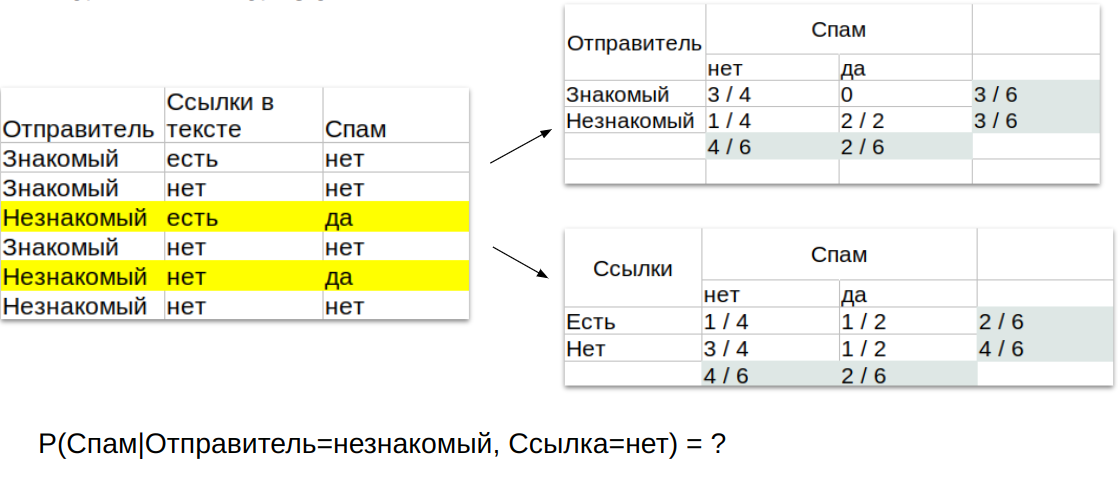

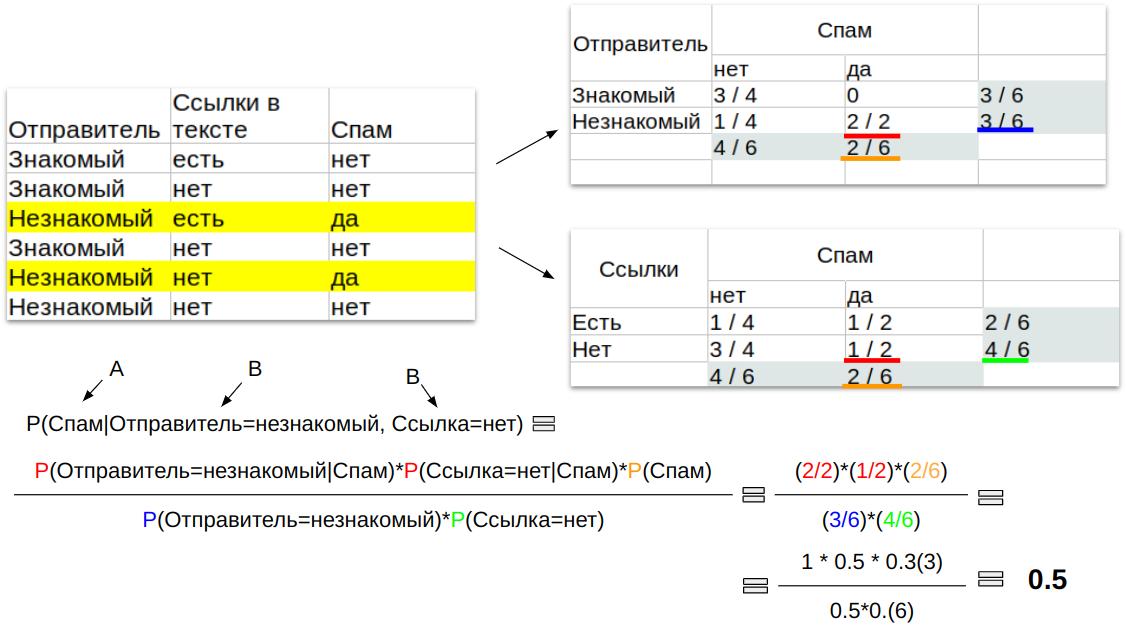

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
clf = GaussianNB()

### Обучение

Обучим классификатор на тренировочных данных.

In [ ]:
# наивный Байес не работает с разреженными матрицами, поэтому применяем .toarray()
clf.fit(X_train.toarray(), y_train)

GaussianNB()

### Предсказание

Мы обучили классификатор. Чтобы проверить, как он работает, применим его на тестовых данных, а затем сравним его предсказания с истинными значениями.

In [ ]:
# применяем метод predict обученного классификатора на тестовых данных (уже преобразованных векторайзером)
# на выходе получаем список предсказанных значений для каждого из тестовых текстов
y_pred = clf.predict(X_test.toarray())

### Результаты

Для начала оценим качество классификации, посмотрев на точность и полноту предсказаний, а также F1-score.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.83       266
           1       0.80      0.97      0.87       277

    accuracy                           0.86       543
   macro avg       0.88      0.85      0.85       543
weighted avg       0.87      0.86      0.85       543



Мы также можем достать названия классов из LabelEncoder:

In [ ]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.96      0.74      0.83       266
    Positive       0.80      0.97      0.87       277

    accuracy                           0.86       543
   macro avg       0.88      0.85      0.85       543
weighted avg       0.87      0.86      0.85       543



Кажется, наша классификация не так уж плоха! Конечно, мы могли слишком хорошо выучить тренировочные данные, но оверфиттинг мы обсудим позже. Пока приступим к анализу ошибок.

Нарисуем **confusion matrix** (матрицу ошибок/матрицу путаницы), чтобы было удобно смотреть, какие классы чаще всего путает модель.

Матрица путаницы - это наглядное представление всех ошибок и верно угаданных моделью значений. По оси X под названием "Predicted label" представлены значения, предсказанные моделью. По оси Y, "True label" - истинные значения. На главной диагонали матрицы ошибок будут те значения, которые модель угадала

**Вопрос:** модель чаще путает негативные твиты с позитивными или позитивные с негативными? Как вы это поняли?

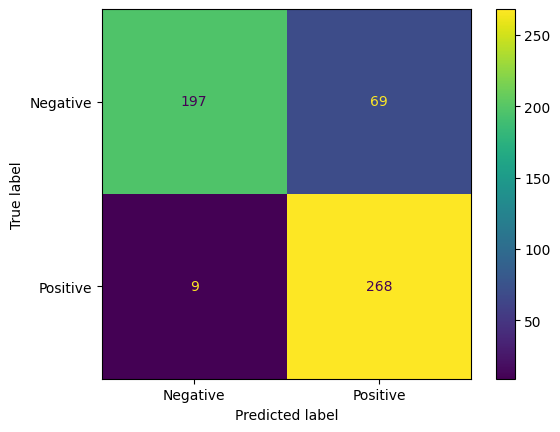

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()

## Упражнения

Попробуйте самостоятельно сделать классификатор нейтральных и нерелевантных твитов. Ориентируйтесь на подсказки в комментариях. Вы можете выбрать любой векторайзер, а также провести любую дополнительную предобработку данных.

Рекомендуется скопировать ячейки ниже в новый ноутбук и делать всё в нём, чтобы не забывать про импорты. Минимальное решение находится в скрытых ячейках ниже.

In [ ]:
# Воспользуйтесь теми же данными
train_neutral_irr = train_twitter.loc[(train_twitter['sentiment'] == 'Neutral') | (train_twitter['sentiment'] == 'Irrelevant')]

In [ ]:
test_neutral_irr = test_twitter.loc[(test_twitter['sentiment'] == 'Neutral') | (test_twitter['sentiment'] == 'Irrelevant')]

In [ ]:
# удалите ряды с пустыми клетками


In [ ]:
# сделайте новый объект векторайзера


In [ ]:
# обучите векторайзер на тренировочных данных


In [ ]:
# преобразуйте тренировочные и тестовые тексты в векторную форму


In [ ]:
# сделайте объект LabelEncoder


In [ ]:
# обучите LabelEncoder на лейблах из вашей тренировочной выборки


In [ ]:
# закодируйте зависимую переменную в тренировочной и тестовой выборке при помощи LabelEncoder


In [ ]:
# объявите объект классификатора


In [ ]:
# обучите классификатор (примените его метод .fit)


In [ ]:
# примените метод predict обученного классификатора на тестовых данных (уже преобразованных векторайзером)


In [ ]:
# выведите classification report


In [ ]:
# отрисуйте матрицу путаницы


### Пример решения

In [ ]:
# @title
# удалите ряды с пустыми клетками
train_neutral_irr = train_neutral_irr.dropna()
test_neutral_irr = test_neutral_irr.dropna()

In [ ]:
# @title
# сделайте новый объект векторайзера
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()

In [ ]:
# @title
# обучите векторайзер на тренировочных данных
vec.fit(train_neutral_irr['tweet'])

CountVectorizer()

In [ ]:
# @title
# преобразуйте тренировочные и тестовые тексты в векторную форму
train_neutral_irr_vectors = vec.transform(train_neutral_irr['tweet'])
test_neutral_irr_vectors = vec.transform(test_neutral_irr['tweet'])

In [ ]:
# @title
# сделайте объект LabelEncoder
le_neutral_irr = LabelEncoder()

In [ ]:
# @title
# обучите LabelEncoder на лейблах из вашей тренировочной выборки
le_neutral_irr.fit(train_neutral_irr['sentiment'])

LabelEncoder()

In [ ]:
# @title
# закодируйте зависимую переменную в тренировочной и тестовой выборке при помощи LabelEncoder
y_train_neutral_irr = le_neutral_irr.transform(train_neutral_irr['sentiment'])
y_test_neutral_irr = le_neutral_irr.transform(test_neutral_irr['sentiment'])

In [ ]:
# @title
# объявите объект классификатора
clf_neutral_irr = GaussianNB()

In [ ]:
# @title
# обучите классификатор (примените его метод .fit)
# если вы видите ошибку STOP: TOTAL NO. of ITERATIONS REACHED LIMIT:
# в клетке выше увеличьте количество итераций у классификатора. По умолчанию их 100.
# LogisticRegression(random_state=0, max_iter=500)
clf_neutral_irr.fit(train_neutral_irr_vectors.toarray(), y_train_neutral_irr)

GaussianNB()

In [ ]:
# @title
# примените метод predict обученного классификатора на тестовых данных (уже преобразованных векторайзером)
y_test_pred_neutral_irr = clf_neutral_irr.predict(test_neutral_irr_vectors.toarray())

In [ ]:
# @title
# выведите classification report
print(classification_report(y_test_neutral_irr, y_test_pred_neutral_irr, target_names=le_neutral_irr.classes_))

              precision    recall  f1-score   support

  Irrelevant       0.80      0.99      0.89       172
     Neutral       1.00      0.85      0.92       285

    accuracy                           0.91       457
   macro avg       0.90      0.92      0.90       457
weighted avg       0.92      0.91      0.91       457



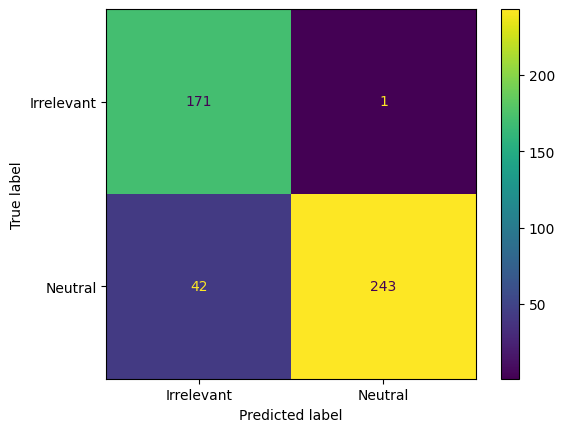

In [ ]:
# @title
# отрисуйте матрицу путаницы
cm = confusion_matrix(y_test_neutral_irr, y_test_pred_neutral_irr)
cm_display = ConfusionMatrixDisplay(cm, display_labels=le_neutral_irr.classes_).plot()